In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import os

import torch
os.chdir('/content/drive/MyDrive/ImitationLearning/Invariant-Causal-Imitation-Learning-main/')


Mounted at /content/drive


# load

In [ ]:
!pip install mpi4py 
!pip install box2d-py
!pip install box2d 
!pip3 install gym[Box_2D] 
!pip install gym==0.17.2 -qqq
!pip install numpy~=1.18.2 -qqq
!pip install pandas~=1.0.4 -qqq
!pip install PyYAML~=5.4.1 -qqq
!pip install scikit-learn~=0.22.2 -qqq
!pip install scipy~=1.1.0 -qqq
!pip install stable-baselines~=2.10.1 -qqq
!pip install tensorflow~=1.15.0 -qqq
!pip install torch>=1.6.0 -qqq
!pip install tqdm~=4.32.1 -qqq


     |████████████████████████████████| 2.5 MB 14.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185232 sha256=8c5fda259edfbe31abac1fa5f203c704bcb58f0428050df682c7477335054171
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
     |████████████████████████████████| 448 kB 14.2 MB/s 
     |████████████████████████████████| 1.3 MB 15.1 MB/s 
     |████████████████████████████████| 1.6 MB 14.9 MB/s 
     |████████████████████████████████| 20.1 MB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 req

#config

In [ ]:

config = {
    "ALG": "NFiVAE_IRMStudent_Apr28",
    "NUM_TRAJS_GIVEN": 20, #
    "NUM_TRAINING_ENVS": 2,
    "NOISE_DIM": 4,
    "REP_SIZE": 16,
    "TRAJ_SHIFT": 20, # 20,
    "SAMPLING_RATE": 5,
    "NUM_STEPS_TRAIN": 10000,
    "NUM_TRAJS_VALID": 100,
    "NUM_REPETITIONS": 15,
    "BATCH_SIZE": 64,
    "MLP_WIDTHS": 64,
    "ADAM_ALPHA": 1e-3,
    "SGLD_BUFFER_SIZE": 10000,
    "SGLD_LEARN_RATE": 0.01,
    "SGLD_NOISE_COEF": 0.01,
    "SGLD_NUM_STEPS": 100,
    "SGLD_REINIT_FREQ": 0.05,
    "NUM_STEPS_TRAIN_ENERGY_MODEL": 1000,
    'TRIAL': 0
}


#config['ENV'] = "LunarLander-v2"
config['ENV'] = "CartPole-v1"

#config['METHOD'] = "BC"
config['METHOD'] = "iVAE_IRM"



if config['METHOD'] == 'BCIRM':
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10000
    config['penalty_anneal_iters'] = 2500
elif config['METHOD'] == "iVAE_IRM":
    config["NUM_STEPS_TRAIN_VAE_MODEL"] = 1500 # phase1
    config["NUM_STEPS_TRAIN"] = 10000 # phase 3
    config['PHASE2_SAMPLES'] = 25000 # phase 2
    config['l2_regularizer_weight'] = 0.001
    config['penalty_weight'] = 10
    config['BATCH_SIZE'] = 50000
    config['MODEL_TYPE'] = 'NFiVAE'
    config['SELECT_PARENTS'] = True
    config['PARENT_THRESHOLD'] = -1
   




config["NUM_REPETITIONS"] = 10
config['SELECT_PARENTS'] = True
config['PARENT_THRESHOLD'] = -1

config['METHOD'] = "iVAE_IRM"



#testing/il

In [ ]:
import argparse
import os
import pickle

import gym
import numpy as np
import pandas as pd
import yaml
import numpy as np

from testing.paths import get_model_path, get_trajs_path  # pylint: disable=reimported

from contrib.energy_model import EnergyModel
from contrib.env_wrapper import EnvWrapper, get_test_mult_factors
from network import EnvDiscriminator
from network import FeaturesDecoder
from network import FeaturesEncoder
from network import MineNetwork 
from network import ObservationsDecoder
from network import StudentNetwork, StudentNetwork_2hidden


from student import ICILStudent, BCStudent, BCIRMStudent, iVAE_IRMStudent, NFiVAE_IRMStudent
from testing.train_utils import fill_buffer, make_agent, save_results
from vae.ivae_wrapper import VAE_wrapper
from vae.nfivae_wrapper import NFiVAE_wrapper
  
from torch import nn

/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


#NFiVAE

In [ ]:
from numbers import Number

import numpy as np
import torch
from torch import distributions as dist
from torch import nn
from torch.nn import functional as F
from torch import autograd
import copy


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers, activation='none', slope=.1, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device
        if isinstance(hidden_dim, Number):
            self.hidden_dim = [hidden_dim] * (self.n_layers - 1)
        elif isinstance(hidden_dim, list):
            self.hidden_dim = hidden_dim
        else:
            raise ValueError('Wrong argument type for hidden_dim: {}'.format(hidden_dim))

        if isinstance(activation, str):
            self.activation = [activation] * (self.n_layers - 1)
        elif isinstance(activation, list):
            self.hidden_dim = activation
        else:
            raise ValueError('Wrong argument type for activation: {}'.format(activation))

        self._act_f = []
        for act in self.activation:
            if act == 'lrelu':
                self._act_f.append(lambda x: F.leaky_relu(x, negative_slope=slope))
            elif act == 'xtanh':
                self._act_f.append(lambda x: self.xtanh(x, alpha=slope))
            elif act == 'sigmoid':
                self._act_f.append(F.sigmoid)
            elif act == 'none':
                self._act_f.append(lambda x: x)
            else:
                ValueError('Incorrect activation: {}'.format(act))

        if self.n_layers == 1:
            _fc_list = [nn.Linear(self.input_dim, self.output_dim)]
        else:
            _fc_list = [nn.Linear(self.input_dim, self.hidden_dim[0])]
            for i in range(1, self.n_layers - 1):
                _fc_list.append(nn.Linear(self.hidden_dim[i - 1], self.hidden_dim[i]))
            _fc_list.append(nn.Linear(self.hidden_dim[self.n_layers - 2], self.output_dim))
        self.fc = nn.ModuleList(_fc_list)
        self.to(self.device)

    @staticmethod
    def xtanh(x, alpha=.1):
        """tanh function plus an additional linear term"""
        return x.tanh() + alpha * x

    def forward(self, x):
        h = x
        for c in range(self.n_layers):
            if c == self.n_layers - 1:
                h = self.fc[c](h)
            else:
                #print("c", c)
                #print("self.fc", self.fc[c])
                #print("h", h)
                #print("self.act_f", self._act_f[c])
                
                h = self._act_f[c](self.fc[c](h))
        return h


class Dist:
    def __init__(self):
        pass

    def sample(self, *args):
        pass

    def log_pdf(self, *args, **kwargs):
        pass


class Normal(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.c = 2 * np.pi * torch.ones(1).to(self.device)
        self._dist = dist.normal.Normal(torch.zeros(1).to(self.device), torch.ones(1).to(self.device))
        self.name = 'gauss'

    def sample(self, mu, v):
        eps = self._dist.sample(mu.size()).squeeze()
        scaled = eps.mul(v.sqrt())
        return scaled.add(mu)

    def log_pdf(self, x, mu, v, reduce=True, param_shape=None):
        """compute the log-pdf of a normal distribution with diagonal covariance"""
        if param_shape is not None:
            mu, v = mu.view(param_shape), v.view(param_shape)
        lpdf = -0.5 * (torch.log(self.c) + v.log() + (x - mu).pow(2).div(v))
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf

    def log_pdf_full(self, x, mu, v):
        """
        compute the log-pdf of a normal distribution with full covariance
        v is a batch of "pseudo sqrt" of covariance matrices of shape (batch_size, d_latent, d_latent)
        mu is batch of means of shape (batch_size, d_latent)
        """
        batch_size, d = mu.size()
        cov = torch.einsum('bik,bjk->bij', v, v)  # compute batch cov from its "pseudo sqrt"
        assert cov.size() == (batch_size, d, d)
        inv_cov = torch.inverse(cov)  # works on batches
        c = d * torch.log(self.c)
        # matrix log det doesn't work on batches!
        _, logabsdets = self._batch_slogdet(cov)
        xmu = x - mu
        return -0.5 * (c + logabsdets + torch.einsum('bi,bij,bj->b', [xmu, inv_cov, xmu]))

    def _batch_slogdet(self, cov_batch: torch.Tensor):
        """
        compute the log of the absolute value of determinants for a batch of 2D matrices. Uses torch.slogdet
        this implementation is just a for loop, but that is what's suggested in torch forums
        gpu compatible
        """
        batch_size = cov_batch.size(0)
        signs = torch.empty(batch_size, requires_grad=False).to(self.device)
        logabsdets = torch.empty(batch_size, requires_grad=False).to(self.device)
        for i, cov in enumerate(cov_batch):
            signs[i], logabsdets[i] = torch.slogdet(cov)
        return signs, logabsdets


class Laplace(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.laplace.Laplace(torch.zeros(1).to(self.device), torch.ones(1).to(self.device) / np.sqrt(2))
        self.name = 'laplace'

    def sample(self, mu, b):
        eps = self._dist.sample(mu.size())
        scaled = eps.mul(b)
        return scaled.add(mu)

    def log_pdf(self, x, mu, b, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            mu, b = mu.view(param_shape), b.view(param_shape)
        lpdf = -torch.log(2 * b) - (x - mu).abs().div(b)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf


class Bernoulli(Dist):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self._dist = dist.bernoulli.Bernoulli(0.5 * torch.ones(1).to(self.device))
        self.name = 'bernoulli'

    def sample(self, p):
        eps = self._dist.sample(p.size())
        return eps

    def log_pdf(self, x, f, reduce=True, param_shape=None):
        """compute the log-pdf of a laplace distribution with diagonal covariance"""
        if param_shape is not None:
            f = f.view(param_shape)
        lpdf = x * torch.log(f) + (1 - x) * torch.log(1 - f)
        if reduce:
            return lpdf.sum(dim=-1)
        else:
            return lpdf






class NFiVAE(nn.Module):
    def __init__(self, latent_dim, data_dim, aux_dim, prior=None, decoder=None, encoder=None,
                 n_layers=3, hidden_dim=50, activation='lrelu', slope=.1, device='cpu', anneal=False, 
                 NF_priors_output_dim=20, NF_priors_n_layers=3, NF_priors_hidden_dim=50, ):
        super().__init__()

        self.data_dim = data_dim
        self.latent_dim = latent_dim
        self.aux_dim = aux_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.activation = activation
        self.slope = slope
        self.anneal_params = anneal

        if prior is None:
            self.prior_dist = Normal(device=device)
        else:
            self.prior_dist = prior

        if decoder is None:
            self.decoder_dist = Normal(device=device)
        else:
            self.decoder_dist = decoder

        if encoder is None:
            self.encoder_dist = Normal(device=device)
        else:
            self.encoder_dist = encoder

        
        self.logl = MLP(aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        # decoder params
        self.f = MLP(latent_dim, data_dim, hidden_dim, n_layers, activation=activation, slope=slope, device=device)
        self.decoder_var = .01 * torch.ones(1).to(device)
        # encoder params
        self.g = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                     device=device)
        self.logv = MLP(data_dim + aux_dim, latent_dim, hidden_dim, n_layers, activation=activation, slope=slope,
                        device=device)

        self.device = device

        # prior_params
        self.prior_mean = torch.zeros(1).to(device)
        
        # 1.1 T_NN(x)
        self.T_NN_x = MLP(latent_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        # 1.2 lambda_NN(Y,E)
        self.lambda_NN_YE = MLP(aux_dim, NF_priors_output_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        
        # 2. T_f(x) and lambda_f(Y,E) are in the second dot product term
          # 2.1 T_f(x) = concat([X, X^2]). This is data dependent, we will define it later during training/evaluation process
          # 2.2 lambda_f(Y,E)
        self.lambda_f_YE = MLP(aux_dim, 2*latent_dim, NF_priors_hidden_dim, NF_priors_n_layers, activation = activation, slope = slope, device = device) 
        #self.T_f_x = torch.hstack([z, z**2])



        self.apply(weights_init)

        self._training_hyperparams = [1., 1., 1., 1., 1]

        self.optimizer_sm = optim.Adam( list(self.T_NN_x.parameters()) + list(self.lambda_NN_YE.parameters()) + list(self.lambda_f_YE.parameters()), lr=0.001)
        
        print("\n***** VAE wrapper created with NFiVAE *****\n")


    def encoder_params(self, x, u):
        xu = torch.cat((x, u), 1)
        g = self.g(xu)
        logv = self.logv(xu)
        return g, logv.exp()

    def decoder_params(self, s):
        f = self.f(s)
        return f, self.decoder_var

    def prior_params(self, z, u):
        T_NN_x = self.T_NN_x(z)
        lambda_NN_YE = self.lambda_NN_YE(u)
        T_f_x = torch.hstack([z, z**2])
        lambda_f_YE = self.lambda_f_YE(u)

        log_x_ye = torch.sum(T_NN_x * lambda_NN_YE, axis = 1) + torch.sum(T_f_x * lambda_f_YE, axis = 1)
        #p_x_ye = log_x_ye.exp()
        #grad = autograd.grad(p_x_ye, [z], create_graph=True)[0]

        #return log_x_ye.exp()
        return log_x_ye
        

    def forward(self, x, u):
        
        encoder_params = self.encoder_params(x, u)
        z = self.encoder_dist.sample(*encoder_params)
        decoder_params = self.decoder_params(z)
        prior_params = self.prior_params(z, u)
        #return decoder_params, encoder_params, z, prior_params
        return decoder_params, encoder_params, z, prior_params

    def prior_1st_derivative_matching(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            derivative_of_log_encoder = ( self.encoder_params(z_plus_new, u) - self.encoder_params(z_minus_new, u) ) / (2*dz)
            derivative_of_log_prior = ( self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u) ) / (2*dz)
            

            
            #sum_derivative += 0.5 * ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            sum_derivative += ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
            
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative
    
    def prior_2nd_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = z.detach() - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz
            
            sum_derivative += (self.prior_params(z_plus_new, u) - 2*self.prior_params(z, u) + self.prior_params(z_minus_new, u)) / dz / dz

        return sum_derivative
        

    def prior_1st_derivative(self, z, u):
        dz = 1e-5
        #z_plus = copy.deepcopy(z.detach()) + dz
        #z_minus = copy.deepcopy(z.detach()) - dz

        z_dim = z.shape[1]
        batch_sz = z.shape[0]

        sum_derivative = torch.zeros(batch_sz).to(self.device)#.reshape(-1,1)
        for i in range(z_dim):
            z_plus_new = copy.deepcopy(z.detach())
            z_minus_new = copy.deepcopy(z.detach())
            
            z_plus_new[:,i] += dz
            z_minus_new[:,i] -= dz

            #print("z_plus_new", z_plus_new)
            #print("z_minus_new", z_minus_new)
            
            sum_derivative += 0.5* ((self.prior_params(z_plus_new, u) - self.prior_params(z_minus_new, u)) / 2 / dz)**2
        
        #print("self.prior_params(z_plus_new, u)", self.prior_params(z_plus_new, u))
        #print("self.prior_params(z_minus_new, u)", self.prior_params(z_minus_new, u))
      
        return sum_derivative





    def elbo(self, x, u):
        decoder_params, (g, v), z, prior_params = self.forward(x, u)
        log_px_z = self.decoder_dist.log_pdf(x, *decoder_params)
        log_qz_xu = self.encoder_dist.log_pdf(z, g, v)
        #log_pz_u = self.prior_dist.log_pdf(z, *prior_params)
        #log_pz_u = torch.log(prior_params[1])
        log_pz_u = (prior_params[1])
        
        
        #print("part1 & 2 = ", (log_px_z + log_pz_u.detach() - log_qz_xu).mean().detach().cpu().numpy(), 
        #                      (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean().detach().cpu().numpy(),
        #                      z.norm().detach().cpu().numpy() )

        vae_loss = (log_px_z + log_pz_u.detach() - log_qz_xu).mean()

        
        sm_loss = self.sliced_score_matching_vr(z, u)[0]
        #sm_loss = (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean()


        self.optimizer_sm.zero_grad()
        sm_loss.backward(retain_graph=True) 
        self.optimizer_sm.step() 

        print("sm_loss:", sm_loss.detach().cpu().numpy())



        #print("vae_loss", -vae_loss.detach().cpu().numpy(), "sm_loss", sm_loss.detach().cpu().numpy(), 'total loss', (-vae_loss + sm_loss).detach().cpu().numpy())
        #return (log_px_z + log_pz_u.detach() - log_qz_xu).mean() -  (self.prior_2nd_derivative(z, u) + self.prior_1st_derivative(z, u)).mean(), z 
        return vae_loss, z 
        
    

    def sliced_score_matching_vr(self, z, ae, n_particles=32):

        dup_z = z.unsqueeze(0).expand(n_particles, *z.shape).contiguous().view(-1, *z.shape[1:])
        dup_ae = ae.unsqueeze(0).expand(n_particles, *ae.shape).contiguous().view(-1, *ae.shape[1:])

        dup_z.requires_grad_(True)
        vectors = torch.randn_like(dup_z)

        #logp = torch.log(self.prior_params(dup_z, dup_ae)+1e-8).sum() # prior_params
        #logp = torch.log(self.prior_params(dup_z, dup_ae)+1e-5).sum() # prior_params
        logp = (self.prior_params(dup_z, dup_ae)).sum() # prior_params
        
        grad1 = autograd.grad(logp, dup_z, create_graph=True)[0]
        loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.
        gradv = torch.sum(grad1 * vectors)
        grad2 = autograd.grad(gradv, dup_z, create_graph=True)[0]
        loss2 = torch.sum(vectors * grad2, dim=-1)

        loss1 = loss1.view(n_particles, -1).mean(dim=0)
        loss2 = loss2.view(n_particles, -1).mean(dim=0)

        loss = loss1 + loss2

        return loss.mean(), loss1.mean(), loss2.mean()


    def anneal(self, N, max_iter, it):
        thr = int(max_iter / 1.6)
        a = 0.5 / self.decoder_var.item()
        self._training_hyperparams[-1] = N
        self._training_hyperparams[0] = min(2 * a, a + a * it / thr)
        self._training_hyperparams[1] = max(1, a * .3 * (1 - it / thr))
        self._training_hyperparams[2] = min(1, it / thr)
        self._training_hyperparams[3] = max(1, a * .5 * (1 - it / thr))
        if it > thr:
            self.anneal_params = False


#NFiVAE-*wrapper*

In [ ]:
import torch
import torch.optim as optim
from torch import autograd, nn
from tqdm import tqdm
from fcit import fcit
import pickle
import numpy as np
#from vae.ivae import iVAE
#from vae.nfivae import NFiVAE
from torch._C import dtype
import torch.nn.functional as F
import random 


class NFiVAE_wrapper:
    def __init__(
        self,
        buffer, 
        data_dim,
        action_dim,
        env_dim = 2,
        latent_dim = 8,
        activation = 'lrelu',
        n_layers = 3,
        hidden_dim = 32,
        lr = 1e-3,
        seed = 0,
        #max_iter = 7e4,
        use_a = True, 
        use_e = False,
        num_updates = 1000,
        ckpt_file = './vae/nfivae_ckpt.pt',
        pa_dict_file = './vae/nfivae_padict.pkl',
        model_type = 'NFiVAE',
        parents_threshold = 2,
        ):
      
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        torch.manual_seed(seed)
        np.random.seed(seed)

        self.state_dim = data_dim
        self.action_dim = action_dim 
        self.latent_dim = latent_dim

        self.buffer = buffer

        if use_a and use_e:
            aux_dim = action_dim + env_dim 
            print("use both actions and env as aux variables")
        elif use_e == False:
            aux_dim = action_dim
            print("use only actions as aux variable")
        
        if model_type == 'iVAE':
            self.model = iVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
        elif model_type == 'NFiVAE':
            self.model = NFiVAE(latent_dim, data_dim, aux_dim, activation='lrelu', device=self.device,
                     n_layers=n_layers, hidden_dim=hidden_dim)
            
        #self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.optimizer = optim.Adam(list(self.model.f.parameters()) + list(self.model.g.parameters()) + list(self.model.logv.parameters()), lr=lr)
        
        #self.optimizer_sm = optim.Adam(self.model.parameters(), lr=lr)

        #self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.1, patience=100, verbose=True)
        self.ckpt_file = ckpt_file
        self.pa_dict_file = pa_dict_file

        self.use_a = use_a 
        self.use_e = use_e

        self.env_dim = env_dim
        print("learning rate of NFiVAE in phase 1:", lr)
        
        self.parents_threshold = parents_threshold


    def train(self, num_updates = 10000):
        
        print("NFiVAE wrapper train buffer sample size = ", self.buffer.sample()['state'].shape)
        
        loss_list = []
        best_window_loss = np.inf
        best_window_loss_num = 0
        self.model.train()
        for update_index in (range(num_updates)):
            loss = self._update_vae_model()
            loss_list.append(loss.detach().cpu())
            
            #if np.mean(loss_list[-100:]) < best_window_loss:
            if loss < best_window_loss:
                #best_window_loss = np.mean(loss_list[-100:])
                best_window_loss = loss
                best_window_loss_num = update_index
                torch.save(self.model.state_dict(), self.ckpt_file)
            """
            if len(loss_list) > 150: # train at least 150 epochs
                if np.mean(loss_list[-100:]) > best_window_loss:
                    self.model.load_state_dict(torch.load(self.ckpt_file))
                    return loss_list
            """
        
            if update_index % 100 ==0:
                print('\repoch {}/{} \tloss: {}'.format(update_index, num_updates, loss), end="")
                #print(update_index, loss)
        #torch.save(self.model.state_dict(), self.ckpt_file)
        
        self.model.load_state_dict(torch.load(self.ckpt_file))
        
        print("best loss model loaded, stored at update #", best_window_loss_num, "with loss", best_window_loss.detach().cpu().numpy())
        
        return loss_list


    def _update_vae_model(self):
        samples = self.buffer.sample()

        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        #self.optimizer.zero_grad()
        self.optimizer.zero_grad()
        elbo, z_est = self.model.elbo(x, ae)
        #elbo, z_est = self.model.vae_loss(x, ae)
        elbo.mul(-1).backward() #loss.backward()
        #elbo.backward() #loss.backward()
        
        self.optimizer.step()

        print("\t\tvae_loss:", elbo.cpu().detach().numpy())

        #self.optimizer_sm.zero_grad()
        #sm = self.model.sm_loss(z_est, ae)
        #sm.backward()
        #self.optimizer_se.step() 

        return elbo.mul(-1) #+ sm
        #return elbo #+ sm
        
        #return elbo_VAE.mul(-1)
        #return elbo.mul(-1)
        


    def predict_latent(self, samples):
        self.model.eval()
        x = torch.FloatTensor(samples["state"]).to(self.device)

        a = F.one_hot(torch.LongTensor(samples['action']), num_classes = self.action_dim)#.to(self.device)
        
        if self.use_a and self.use_e:
            e = F.one_hot(torch.LongTensor(samples['env']), num_classes = self.env_dim)#.to(self.device)
            ae = torch.cat((a, e), 1).to(torch.float32).to(self.device)
        elif self.use_e == False:
            ae = a.to(torch.float32).to(self.device)

        _, _, z, _ = self.model(x, ae)
        return z


    def _get_random_states(self, num_states):
        return torch.FloatTensor(num_states, self.in_dim).uniform_(-1, 1)








    ############################        phase 2.       #########################
    ############################        phase 2.       #########################
    ############################        phase 2.       #########################


    def phase2_sampled_data(self, n_samples = 1000):

        
        n_queries = n_samples // self.buffer.batch_size + 1
      
        actions = []
        states = []
        latents = []

        for i in range(n_queries):
            samples = self.buffer.sample()
            actions.append(samples['action'].reshape(-1,1))
            states.append(samples['state'])
            z = self.predict_latent(samples)
            latents.append(z.detach().cpu().numpy())

        actions = np.concatenate(np.vstack(actions))[:n_samples].reshape(-1,1).astype(int)
        states = np.concatenate((states), axis = 0)[:n_samples]
        latents = np.concatenate((latents), axis = 0)[:n_samples]

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        
        
        """
        samples = self.buffer.sample_all()
        actions = (samples['action'].reshape(-1,1)).astype(int)
        states = (samples['state'])
        z = self.predict_latent(samples)
        latents = (z.detach().cpu().numpy())

        actions = np.eye(actions.max()+1)[actions][:,0,:] # convert to one-hoc encoding
        """

        return states, latents, actions

        
    def phase2_find_parents(self, latents, actions):

        parents = []

        num_vars = latents.shape[1]

        for i in range(num_vars-1):
            for j in range(i+1, num_vars):
                pval_d = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1))
                pval_i = fcit.test(latents[:,i].reshape(-1,1), latents[:,j].reshape(-1,1), actions)
                if pval_d < pval_i:
                    print('{} and {} are independent with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                else:
                    print('{} and {} are DEPENDENT with pval_d={} and pval_i={}'.format(i, j, pval_d, pval_i))
                    parents.append(i)
                    parents.append(j)

        parents_set = set(parents)

        parents_dict = {}
        for p in parents_set:
            parents_dict[p] = parents.count(p)
            
        for i in range(num_vars):
            if i not in parents_set:
                parents_dict[i] = 0

        parents_dict_sorted = {}
        for w in sorted(parents_dict, key=parents_dict.get, reverse=True):
            print(w, parents_dict[w])
            if parents_dict[w]>self.parents_threshold:
                parents_dict_sorted[w] = parents_dict[w]

        return list(parents_dict_sorted.keys()), parents_dict_sorted


    def start_phase2(self, n_samples = 50000, save = True):

        print("\n***** Starts Phase 2 *****")
        
        #n_samples = self.buffer.sample_all()['state'].shape[0] * 2
        
        print("phase 2: n_samples = ", n_samples)
        
        states, latents, actions = self.phase2_sampled_data(n_samples)
        pa_list, pa_dict = self.phase2_find_parents(latents, actions)

        self.pa_list = sorted(pa_list)
        self.pa_dict = pa_dict 
        
        print("parent list:", self.pa_list)

        if save:
            pickle.dump(self.pa_dict, open(self.pa_dict_file, "wb"))

        return pa_list, pa_dict


    
    

# tests

In [ ]:
traj_num = 10

config["NUM_TRAJS_GIVEN"] = traj_num
config["TRAJ_SHIFT"] = traj_num


config['ALG'] = "test35_May13_phase1test_NFiVAEStudent_replicatedata_trajnum" + str(traj_num)


###############.  settings   ###############

#if config['METHOD'] == 'iVAE_IRM':


all_results_trail = []


trail = 0

config['TRIAL'] = trail 

print("batch size = ", config['BATCH_SIZE'])


###############.  start a trail   ###############

config["EXPERT_ALG"] = yaml.load(open("testing/config.yml"), Loader=yaml.FullLoader)[config["ENV"]]
print("Config: %s" % config)

TRIAL = config["TRIAL"] #args.trial
print("Trial number %s" % TRIAL)

results_dir_base = "testing/results/"
results_dir = os.path.join(results_dir_base, config["ENV"], str(config["NUM_TRAJS_GIVEN"]), config["ALG"])

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

config_file = "trial_" + str(TRIAL) + "_" + "config.pkl"

results_file_name = "trial_" + str(TRIAL) + "_" + "results.csv"
results_file_path = os.path.join(results_dir, results_file_name)

if os.path.exists(os.path.join(results_dir, config_file)):
    raise NameError("CONFIG file already exists %s. Choose a different trial number." % config_file)
pickle.dump(config, open(os.path.join(results_dir, config_file), "wb"))




###############.  10 runs for each trail   ###############

print("config method = ", config['METHOD'])
print("config env = ", config['ENV'])

run_seed = 0

batch size =  50000
Config: {'ALG': 'test35_May13_phase1test_NFiVAEStudent_replicatedata_trajnum10', 'NUM_TRAJS_GIVEN': 10, 'NUM_TRAINING_ENVS': 2, 'NOISE_DIM': 4, 'REP_SIZE': 16, 'TRAJ_SHIFT': 10, 'SAMPLING_RATE': 5, 'NUM_STEPS_TRAIN': 10000, 'NUM_TRAJS_VALID': 100, 'NUM_REPETITIONS': 10, 'BATCH_SIZE': 50000, 'MLP_WIDTHS': 64, 'ADAM_ALPHA': 0.001, 'SGLD_BUFFER_SIZE': 10000, 'SGLD_LEARN_RATE': 0.01, 'SGLD_NOISE_COEF': 0.01, 'SGLD_NUM_STEPS': 100, 'SGLD_REINIT_FREQ': 0.05, 'NUM_STEPS_TRAIN_ENERGY_MODEL': 1000, 'TRIAL': 0, 'ENV': 'CartPole-v1', 'METHOD': 'iVAE_IRM', 'NUM_STEPS_TRAIN_VAE_MODEL': 1500, 'PHASE2_SAMPLES': 25000, 'l2_regularizer_weight': 0.001, 'penalty_weight': 10, 'MODEL_TYPE': 'NFiVAE', 'SELECT_PARENTS': True, 'PARENT_THRESHOLD': -1, 'EXPERT_ALG': 'dqn', 'LATENT_DIM': 7}
Trial number 0
config method =  iVAE_IRM
config env =  CartPole-v1


/content/drive/.shortcut-targets-by-id/1OMkIazT1mDvTsmoHYHfcjKlWdwFWLOpV/ImitationLearning/Invariant-Causal-Imitation-Learning-main/testing/train_utils.py:106: UserWarning: Buffer smaller than batch size
  warnings.warn("Buffer smaller than batch size")


state_dim 8

 ***** Start Phase 1 ***** 

latent dim =  7
use both actions and env as aux variables

***** VAE wrapper created with NFiVAE *****

learning rate of NFiVAE in phase 1: 0.001
NFiVAE wrapper train buffer sample size =  (1979, 8)
sm_loss: -0.45756793
		vae_loss: -235.08844
epoch 0/1500 	loss: 235.08843994140625sm_loss: -0.81304854
		vae_loss: -222.01863
sm_loss: -1.0877209
		vae_loss: -207.12549
sm_loss: -1.4887792
		vae_loss: -196.98744
sm_loss: -1.8401535
		vae_loss: -184.95226
sm_loss: -2.0894113
		vae_loss: -170.868
sm_loss: -2.4096909
		vae_loss: -159.51552
sm_loss: -2.7650301
		vae_loss: -150.29135
sm_loss: -3.0103936
		vae_loss: -141.32571
sm_loss: -3.1775832
		vae_loss: -136.43686
sm_loss: -3.458612
		vae_loss: -128.59045
sm_loss: -3.6650608
		vae_loss: -121.90065
sm_loss: -3.8797855
		vae_loss: -113.01845
sm_loss: -4.1458516
		vae_loss: -109.56905
sm_loss: -4.4042287
		vae_loss: -102.44202
sm_loss: -4.6718736
		vae_loss: -99.90761
sm_loss: -4.990567
		vae_loss: -99.

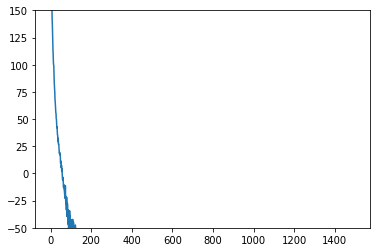

In [ ]:
env = gym.make(config["ENV"])
trajs_path = get_trajs_path(config["ENV"], "student_" + config["ALG"], env_id="student", run_seed=run_seed)
model_path = get_model_path(config["ENV"], "student_" + config["ALG"], run_seed=run_seed)

state_dim = env.observation_space.shape[0] + config["NOISE_DIM"]
action_dim = env.action_space.n
num_training_envs = config["NUM_TRAINING_ENVS"]

# run_seed = run_seed
batch_size = config["BATCH_SIZE"]
teacher = make_agent(config["ENV"], config["EXPERT_ALG"], config["NUM_TRAINING_ENVS"])
teacher.load_pretrained()

buffer = fill_buffer(
    trajs_path=teacher.trajs_paths,
    batch_size=batch_size,
    run_seed=run_seed,
    traj_shift=config["TRAJ_SHIFT"],
    buffer_size_in_trajs=config["NUM_TRAJS_GIVEN"],
    sampling_rate=config["SAMPLING_RATE"],
)

if buffer.total_size < batch_size:
    batch_size = buffer.total_size



##########################      COMMON      ##########################

print("state_dim", state_dim)

causal_features_encoder = FeaturesEncoder(
    input_size=state_dim, representation_size=config["REP_SIZE"], width=config["MLP_WIDTHS"]
)

policy_network = StudentNetwork(in_dim=config["REP_SIZE"], out_dim=action_dim, width=config["MLP_WIDTHS"])




##########################       iVAE IRM       #######################


print("\n ***** Start Phase 1 ***** \n")

config['LATENT_DIM'] = state_dim  -1 # - 3  # latent dim for iVAE, not causal-feature-encoder and policy-network

print("latent dim = ", config['LATENT_DIM'] )


ckpt_file = './vae/' + 'CartPole_partA_nfivae_ckpt.pt' #'./vae/' + config['ENV'] +'nfivae_ckpt.pt',
pa_dict_file =  './vae/' + 'CartPole_partA_nfivae_padict.pkl' #'./vae/' + config['ENV'] +'nfivae_padict.pkl',

vae_wrapper =  NFiVAE_wrapper(buffer, data_dim = state_dim, action_dim = action_dim, env_dim = config['NUM_TRAINING_ENVS'], latent_dim = config['LATENT_DIM'], 
                            use_e = True, model_type= config['MODEL_TYPE'], lr = 1e-3, pa_dict_file = pa_dict_file, ckpt_file = ckpt_file, parents_threshold = config['PARENT_THRESHOLD'])



loss_list = vae_wrapper.train(num_updates=config["NUM_STEPS_TRAIN_VAE_MODEL"])#.cpu()

import matplotlib.pyplot as plt
plt.plot((np.array(loss_list)))
plt.ylim(-50,150)
plt.show()



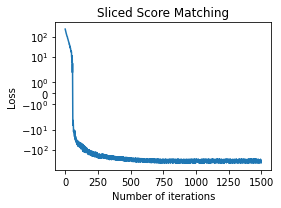

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(torch.stack(loss_list).numpy())
plt.yscale('symlog')
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.title("Sliced Score Matching")
plt.tight_layout()
plt.savefig('SSM_loss_new.png', dpi = 150)